# Multiclasificación en el Amazonas!

Usando imágenes satelitales, tenemos que decidir algunas condiciones.

El dataset original viene de este concurso de kaggle: [https://www.kaggle.com/c/planet-understanding-the-amazon-from-space](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space)

Sin embargo, nosotros, para que lo puedan seguir con recursos limitados, usaremos un muy pequeño sample que proporciona fast.ai.

Obviamente no llegaremos a ganar el leaderboard del concurso, pero las mismas cosas nos llevarían a estar cerca del top 20 si entrenáramos con todos los datos (y con modelos más grandes).

In [5]:
import fastai.vision.all as fv
import torch
import torch.nn as nn
import torch.nn.functional as F

import random
import pandas as pd
from pathlib import Path

In [6]:
path = fv.untar_data(fv.URLs.PLANET_SAMPLE)

In [7]:
path.ls()

(#2) [Path('/home/mraggi/.fastai/data/planet_sample/labels.csv'),Path('/home/mraggi/.fastai/data/planet_sample/train')]

In [8]:
(path/'train').ls()

(#1000) [Path('/home/mraggi/.fastai/data/planet_sample/train/train_1876.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_24649.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_37360.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_26305.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_36684.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_28448.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_13523.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_8779.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_30915.jpg'),Path('/home/mraggi/.fastai/data/planet_sample/train/train_15763.jpg')...]

In [9]:
imgs = (path/'train').ls()

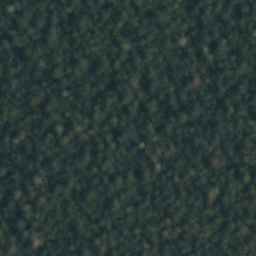

In [10]:
fv.PILImage.create(imgs[42])

In [11]:
fv.PILImage.create(imgs[19]).width

256

In [12]:
df = pd.read_csv(path/'labels.csv'); df

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road
...,...,...
995,train_1876,cloudy
996,train_10311,clear primary road water
997,train_19080,clear primary
998,train_39339,clear primary road


In [13]:
file2tags = dict(zip(df['image_name'],df['tags']))
{k: v for k, v in file2tags.items() if random.random() < 0.01}

{'train_36793': 'clear primary',
 'train_25459': 'agriculture clear cultivation primary road',
 'train_35871': 'clear primary road',
 'train_33002': 'agriculture clear habitation primary road',
 'train_20419': 'clear primary',
 'train_24389': 'clear primary',
 'train_32445': 'agriculture partly_cloudy primary',
 'train_34866': 'agriculture clear primary',
 'train_17695': 'agriculture clear primary',
 'train_23399': 'clear primary',
 'train_14298': 'agriculture haze primary road'}

In [14]:
def obtener_categorias(f):
    return file2tags[f.stem]

In [15]:
obtener_categorias(imgs[19])

'agriculture habitation partly_cloudy primary road'

In [16]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert=True, 
                             max_rotate=360, 
                             max_lighting=0.35, 
                             max_zoom=1.1, 
                             max_warp=0.01)
    
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = obtener_categorias,
                        splitter  = fv.RandomSplitter(1/10),
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms= tfms,
                       )
    return data.dataloaders(folder, bs=batch_size)

In [17]:
data = load_data(path,224,128)

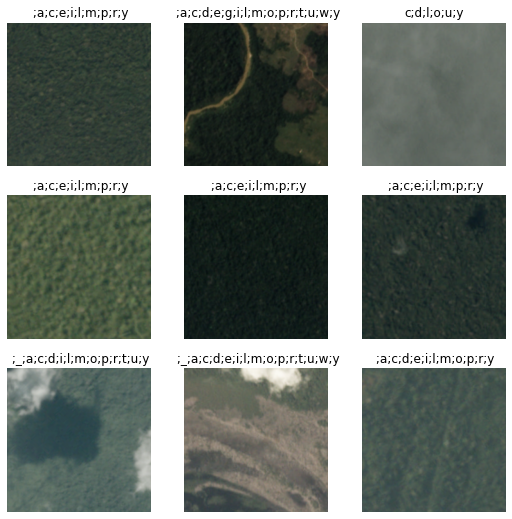

In [18]:
data.show_batch()

Uh... ¿qué pasó? Ah, pues que nuestra función "obtener_categoria" está mal: regresa solo la string, pero quiero que regrese una lista con las categorías correspondientes:

In [19]:
def obtener_categorias(f):
    return file2tags[f.stem].split(' ')

In [20]:
obtener_categorias(imgs[19])

['agriculture', 'habitation', 'partly_cloudy', 'primary', 'road']

In [21]:
def load_data(folder, img_size, batch_size):
    tfms = fv.aug_transforms(size = img_size,
                             flip_vert=True, 
                             max_rotate=360, 
                             max_lighting=0.35, 
                             max_zoom=1.1, 
                             max_warp=0.01)
    
    data = fv.DataBlock(blocks    = (fv.ImageBlock, fv.MultiCategoryBlock),
                        get_items = fv.get_image_files,
                        get_y     = obtener_categorias,
                        splitter  = fv.RandomSplitter(1/10),
                        item_tfms = fv.Resize(int(1.5*img_size)),
                        batch_tfms= tfms,
                       )
    return data.dataloaders(folder, bs=batch_size)

In [22]:
data = load_data(path,224,128)

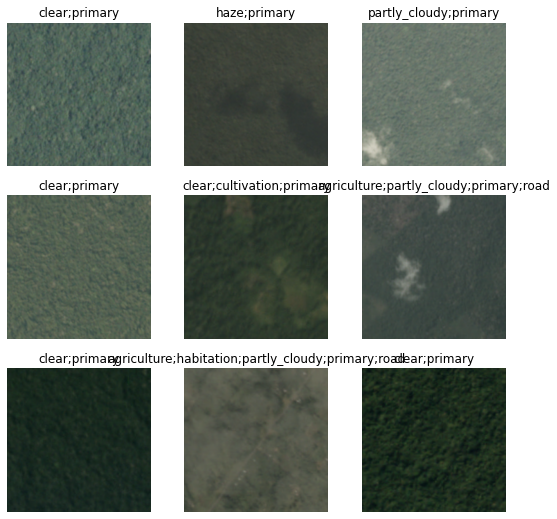

In [23]:
data.show_batch()

In [25]:
x,y = data.one_batch()

In [26]:
x.shape

torch.Size([128, 3, 224, 224])

In [27]:
y.shape

torch.Size([128, 17])

In [28]:
y[:3]

TensorMultiCategory([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.]],
       device='cuda:0')

In [29]:
class Normalizer(nn.Module):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        super().__init__()
        self.mean= torch.tensor(mean)[None,:,None,None]
        self.std = torch.tensor(std)[None,:,None,None]
        
    def forward(self, x):
        m = self.mean.to(x)
        s = self.std.to(x)
        return (x - m)/s

In [30]:
def create_learner(**kwargs):
    learn = fv.vision_learner(data, fv.resnet18, opt_func=fv.ranger, normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), learn.model)
    return learn.to_fp16()

In [31]:
learn = create_learner(metrics=fv.accuracy_multi)

In [32]:
learn.model

Sequential(
  (0): Normalizer()
  (1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d

## Nuestras predicciones

Al final la red neuronal escupe 17 cosas: una por cada categoría (al igual que escupía 102 en las flores). La diferencia es que ahora en vez de conceptualmente aplicar softmax, conceptualmente aplicamos sigmoide: cada categoría puede cumplirse o no, independientemente de las otras.

In [33]:
learn.loss_func

FlattenedLoss of BCEWithLogitsLoss()

## BCE loss

¿Qué es BCEWithLogitsLoss?

BCE significa "Binary Cross Entropy": Es decir, hace cross entropy en CADA categoría, sólo con tu predicción.

Lo de "with logits" solo significa que el modelo no le pone al final una capa sigmoide, y entonces calcula la pérdida así (y es más numéricamente estable).

In [34]:
F.binary_cross_entropy_with_logits?

Signature:
F.binary_cross_entropy_with_logits(
    input,
    target,
    weight=None,
    size_average=None,
    reduce=None,
    reduction='mean',
    pos_weight=None,
)
Docstring:
Function that measures Binary Cross Entropy between target and output
logits.

See :class:`~torch.nn.BCEWithLogitsLoss` for details.

Args:
    input: Tensor of arbitrary shape
    target: Tensor of the same shape as input
    weight (Tensor, optional): a manual rescaling weight
        if provided it's repeated to match input tensor shape
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the losses are instead summed for each minibatch. Ignored
        when reduce is ``False``. Default: ``True``
    reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, th

In [35]:
F.binary_cross_entropy?

Signature:
F.binary_cross_entropy(
    input,
    target,
    weight=None,
    size_average=None,
    reduce=None,
    reduction='mean',
)
Docstring:
Function that measures the Binary Cross Entropy
between the target and the output.

See :class:`~torch.nn.BCELoss` for details.

Args:
    input: Tensor of arbitrary shape
    target: Tensor of the same shape as input
    weight (Tensor, optional): a manual rescaling weight
            if provided it's repeated to match input tensor shape
    size_average (bool, optional): Deprecated (see :attr:`reduction`). By default,
        the losses are averaged over each loss element in the batch. Note that for
        some losses, there multiple elements per sample. If the field :attr:`size_average`
        is set to ``False``, the losses are instead summed for each minibatch. Ignored
        when reduce is ``False``. Default: ``True``
    reduce (bool, optional): Deprecated (see :attr:`reduction`). By default, the
        losses are averaged or s

/home/mraggi/anaconda3/envs/fastai2/lib/python3.8/site-packages/fastai/learner.py:53: UserWarning: Could not load the optimizer state.
  if with_opt: warn("Could not load the optimizer state.")


SuggestedLRs(lr_min=0.05248074531555176, lr_steep=0.12022644281387329)

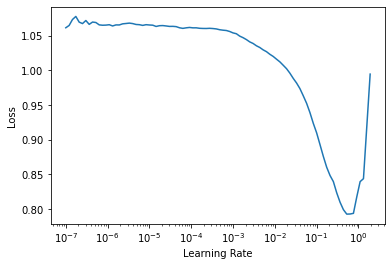

In [36]:
learn.lr_find()

In [37]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.908045,0.742772,0.571765,00:02


# Score F2

Bueno, pero si vamos a la página de kaggle: https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview/evaluation

podemos ver que evalúan el puntaje $F_2$, no la accuracy!

In [ ]:
fv.FBetaMulti(beta=2,average='samples')

In [38]:
learn = create_learner(metrics=[fv.accuracy_multi,fv.FBetaMulti(beta=2, average='samples')])

In [39]:
learn.fit_one_cycle(4,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,1.072111,0.725727,0.575882,0.352102,00:02
1,1.023311,0.687425,0.686471,0.647794,00:02
2,0.947537,0.594588,0.700000,0.646121,00:02
3,0.877514,0.560667,0.725294,0.662564,00:02


In [40]:
thresholds = [0.1,0.25,0.5,0.75]
metrics = [fv.FBetaMulti(beta=2,thresh=t) for t in thresholds]

metrics += [fv.accuracy_multi]

learn = create_learner(metrics=metrics)

In [41]:
learn.fit_one_cycle(1,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,fbeta_score,fbeta_score,fbeta_score,fbeta_score,accuracy_multi,time
0,1.053598,0.752098,0.332597,0.311246,0.250247,0.118949,0.548824,00:02


In [42]:
fv.AccumMetric.name = ""
thresholds = [0.1,0.25,0.5,0.75,0.9]
metrics = [fv.FBetaMulti(beta=2,thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"

metrics += [fv.accuracy_multi]

In [43]:
learn = create_learner(metrics=metrics)

In [44]:
learn.fit_one_cycle(12,2e-2,div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,F2@0.1,F2@0.25,F2@0.5,F2@0.75,F2@0.9,accuracy_multi,time
0,1.058811,0.787248,0.476880,0.434608,0.317190,0.103374,0.011534,0.518235,00:02
1,1.011191,0.728440,0.490273,0.506519,0.546982,0.521699,0.426371,0.677059,00:02
2,0.939605,0.620440,0.489474,0.520702,0.623762,0.530555,0.303744,0.715882,00:02
3,0.868336,0.525539,0.495333,0.550996,0.724508,0.615265,0.434565,0.791765,00:02
4,0.794554,0.420606,0.502342,0.607492,0.805700,0.697512,0.479407,0.866471,00:02
5,0.712041,0.268673,0.552824,0.807708,0.848919,0.798969,0.539662,0.937059,00:02
6,0.623399,0.169007,0.777258,0.866404,0.855056,0.792258,0.717483,0.949412,00:02
7,0.544633,0.151506,0.866756,0.869779,0.823890,0.764569,0.716632,0.947059,00:02
8,0.475864,0.132915,0.875639,0.890385,0.851949,0.798163,0.734905,0.954706,00:02
9,0.420844,0.136734,0.878316,0.886488,0.864284,0.784011,0.756861,0.954706,00:02


In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(12,slice(3e-5,1e-3),div=0.9,pct_start=0.75)

epoch,train_loss,valid_loss,F2@0.1,F2@0.25,F2@0.5,F2@0.75,F2@0.9,accuracy_multi,time
0,0.138102,0.127492,0.876355,0.891302,0.850250,0.784590,0.753239,0.955882,00:03
1,0.134949,0.123730,0.876033,0.890539,0.843486,0.801294,0.750022,0.955882,00:02
2,0.134403,0.121622,0.880881,0.898185,0.848628,0.802477,0.740022,0.957059,00:03
3,0.132185,0.120855,0.883117,0.904417,0.842517,0.805524,0.750022,0.955882,00:03
4,0.130575,0.120144,0.883023,0.904965,0.854082,0.806159,0.746769,0.957059,00:02
5,0.129834,0.117361,0.893155,0.900018,0.848075,0.808498,0.742325,0.956471,00:02
6,0.128406,0.118487,0.882408,0.893816,0.848635,0.806796,0.744071,0.957059,00:02
7,0.126493,0.118736,0.887189,0.899635,0.848059,0.814891,0.739117,0.957059,00:02
8,0.124559,0.117645,0.890943,0.897482,0.848910,0.817230,0.745950,0.956471,00:02
9,0.123225,0.120722,0.890196,0.893078,0.843153,0.813443,0.753151,0.957059,00:02


In [47]:
thresholds = [0.15 + i*0.01 for i in range(20)]
metrics = [fv.FBetaMulti(beta=2, thresh=t, average='samples') for t in thresholds]

for m,t in zip(metrics,thresholds):
    m.name = f"F2@{t}"

metrics += [fv.accuracy_multi]

In [48]:
learn.metrics = metrics

In [49]:
learn.validate()

(#22) [0.11907432228326797,0.9111602379533421,0.9085844803775843,0.9101684220350557,0.9088243360135502,0.9046325925718068,0.9020389328508651,0.8966494976081689,0.8966494976081689,0.8954658664245377...]

In [ ]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class RandomResize(nn.Module):
    def __init__(self, sizes):
        super().__init__()
        self.sizes = sizes
        self.on = True
    
    def turn_off(self): self.on = False
    def turn_on(self): self.on = True
    
    def forward(self, x):
        if self.training and self.on:
            size = random.choice(self.sizes)
            if size == x.shape[2]:
                return x
            else:
                return F.interpolate(x,size=size,mode='bilinear',align_corners=True)
        return x

In [ ]:
data = load_data("Planet/",256,64)

In [ ]:
def create_learner(**kwargs):
    learn = fv.cnn_learner(data, fv.resnet50, opt_func=fv.ranger, normalize=False, **kwargs)
    learn.model = nn.Sequential(Normalizer(), RandomResize([128,160,192,256]), learn.model)
    return learn.to_fp16()

In [ ]:
learn = create_learner(metrics=metrics)

In [ ]:
learn.fit_one_cycle(12,3e-2,div=1,div_final=1000,pct_start=0.75)

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(12,slice(1e-4,3e-3),div=1,div_final=1000,pct_start=0.5)

In [ ]:
learn.model[1].turn_off()

In [ ]:
learn.fit_one_cycle(1,slice(1e-4,1e-3),div=1,pct_start=0.5)